In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, kstest, spearmanr, levene
from statsmodels.stats.multitest import multipletests

In [2]:
csv_file_path = 'data/data_all_cleaned.csv'
data_raw = pd.read_csv(csv_file_path)

data = data_raw.copy()

print('Cantidad de participantes: ', len(data))
data.head()

Cantidad de participantes:  604


,ext1,ext2,ext3,ext4,ext5,ext6,ext7,ext8,ext9,ext10,...,birth_location_country_clean,age,age_group,openness_score,conscientiousness_score,extraversion_score,agreeableness_score,neuroticism_score,zodiac_sign,zodiac_group
0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,Argentina,25,18-30,48.0,33.0,41.0,42.0,28.0,Leo,Fuego
1,4.0,5.0,3.0,4.0,5.0,5.0,3.0,3.0,2.0,2.0,...,Argentina,26,18-30,50.0,35.0,36.0,44.0,35.0,Aries,Fuego
2,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,...,Spain,23,18-30,42.0,31.0,35.0,31.0,40.0,Acuario,Aire
3,2.0,3.0,4.0,3.0,3.0,2.0,4.0,3.0,3.0,3.0,...,Argentina,56,46-59,36.0,31.0,30.0,42.0,36.0,Capricornio,Tierra
4,3.0,2.0,2.0,3.0,5.0,5.0,5.0,2.0,1.0,1.0,...,Argentina,28,18-30,43.0,33.0,29.0,41.0,20.0,Piscis,Agua


Variables categóricas no ordinales: 'degree_category', 'gender', 'birth_location_country_clean', 'zodiac_sign', 'zodiac_group'
Variables categóricas ordinales: 'age_group'
Variables discretas: 'happiness_level', 'birth_date', 'age', 'openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score'

Para todo lo que es las categóricas no ordinales, Mann-Whitney U test.


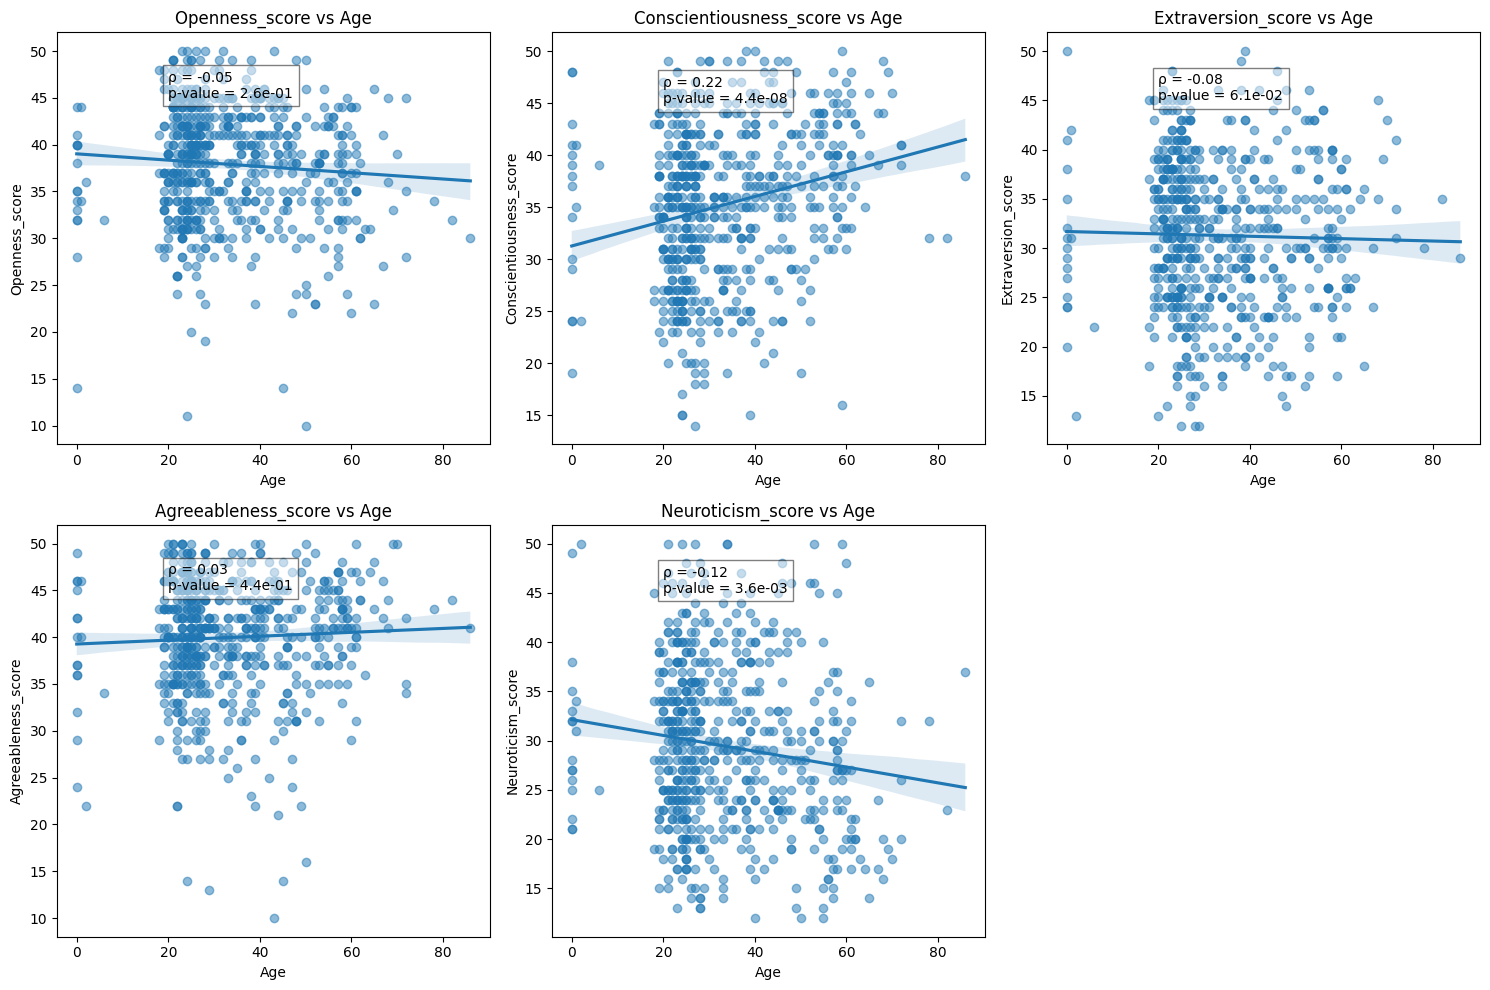

In [3]:
personality_traits = ['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']

# Plotting personality traits against age with trend lines and displaying formatted correlation and p-value
plt.figure(figsize=(15, 10))

for i, trait in enumerate(personality_traits, 1):
    plt.subplot(2, 3, i)
    sns.regplot(x=data['age'], y=data[trait], scatter_kws={'alpha':0.5})
    
    # Calculating Spearman correlation and p-value
    correlation, p_value = spearmanr(data['age'], data[trait])
    
    plt.title(f'{trait.capitalize()} vs Age')
    plt.xlabel('Age')
    plt.ylabel(trait.capitalize())
    plt.text(20, max(data[trait])*0.9, f'ρ = {correlation:.2f}\np-value = {p_value:.1e}', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

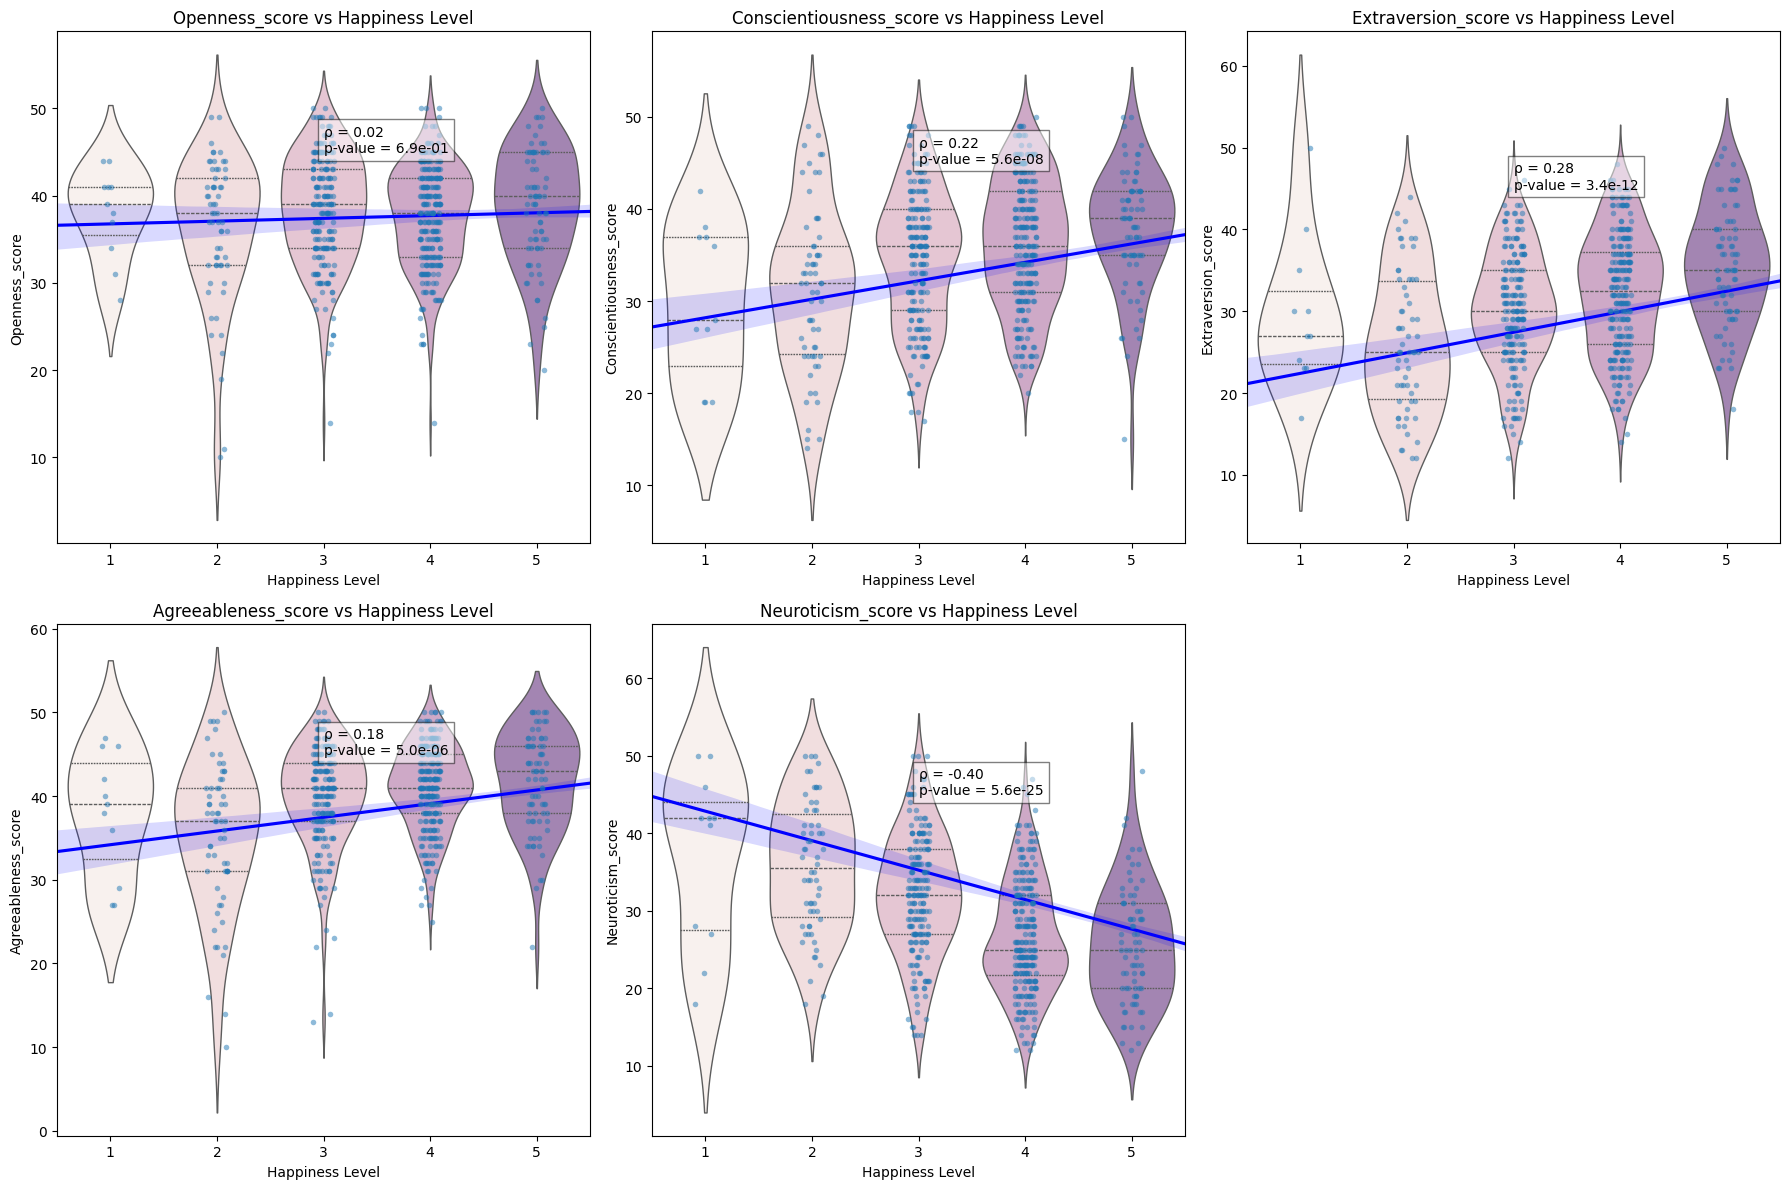

In [4]:
plt.figure(figsize=(18, 12))

for i, trait in enumerate(personality_traits, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x=data['happiness_level'], y=data[trait], linewidth=1, inner='quartile', palette=sns.cubehelix_palette(5, start=.1, gamma=0.3), legend=False, hue=data['happiness_level'])
    sns.stripplot(x=data['happiness_level'], y=data[trait], size=4, jitter=True, alpha=0.5)
    sns.regplot(x='happiness_level', y=trait, data=data, scatter=False, color='blue', truncate=False)

    # Calculating Spearman correlation and p-value
    correlation, p_value = spearmanr(data['happiness_level'], data[trait])

    plt.title(f'{trait.capitalize()} vs Happiness Level')
    plt.xlabel('Happiness Level')
    plt.ylabel(trait.capitalize())
    plt.text(2, max(data[trait])*0.9, f'ρ = {correlation:.2f}\np-value = {p_value:.1e}', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


In [23]:
def compare_two_groups(data, category, trait, group1, group2):
    data_group_1 = data[data[category] == group1][trait]
    data_group_2 = data[data[category] == group2][trait]

    # Check para ver si hay suficientes datos
    if len(data_group_1) < 3 or len(data_group_2) < 3:
        return {
            'group1_size': len(data_group_1),
            'group2_size': len(data_group_2),
            'test_type': 'Insufficient data',
            'p_value': 1,
        }

    test_result = mannwhitneyu(data_group_1, data_group_2)

    return {
        'group1_mean': round(data_group_1.mean(), 2),
        'group2_mean': round(data_group_2.mean(), 2),
        'group1_size': len(data_group_1),
        'group2_size': len(data_group_2),
        'test_type': 'Mann-Whitney U',
        'p_value': test_result.pvalue
    }

def perform_all_group_comparisons(data, category, trait):
    groups = data[category].unique()
    all_findings = []
    significant_findings = []
    all_p_values = []

    for i in range(len(groups)):
        for j in range(i, len(groups)):
            if j == i:
                continue
            result = compare_two_groups(data, category, trait, groups[i], groups[j])
            all_p_values.append(result['p_value'])
            all_findings.append({
                'category_one': groups[i],
                'category_two': groups[j],
                'trait': trait,
                'group1_mean': result['group1_mean'] if 'group1_mean' in result else None,
                'group2_mean': result['group2_mean'] if 'group2_mean' in result else None,
                'group1_size': result['group1_size'] if 'group1_size' in result else None,
                'group2_size': result['group2_size'] if 'group2_size' in result else None,
                'p_value': result['p_value'],
                'test_type': result['test_type']
            })

    significant_findings = [result for result in all_findings if result['p_value'] < 0.05]

    bonferroni_adjusted = multipletests(all_p_values, method='bonferroni')[0]

    return {
        'tests_conducted': len(all_findings),
        'significant_findings': significant_findings,
        'bonferroni_findings': [sig for sig, adj in zip(all_findings, bonferroni_adjusted) if adj]
    }

def format_results(results, category, trait):
    class Colors:
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        FAIL = '\033[91m'
        GREEN = '\033[92m'
        WARNING = '\033[93m'
        HEADER = '\033[95m'

    print('---------------------------------')
    print(f'{Colors.HEADER}Categoría analizada: {category} en {trait} {Colors.ENDC}')
    print('---------------------------------')
    print(f'# Tests: ' + str(results['tests_conducted']))
    print(f'Descubrimientos significativos (p-value < 0.05): ' + Colors.WARNING + str(len(results['significant_findings'])) + Colors.ENDC)
    print(f'Aplicando el método Bonferroni: ' + str(len(results['bonferroni_findings'])))

    if len(results['bonferroni_findings']) == 0:
        print(Colors.FAIL + 'No se encontraron descubrimientos significativos con el método de Bonferroni.' + Colors.ENDC)
    elif len(results['bonferroni_findings']) > 0:
        print('---------------------------------')
        print(Colors.GREEN + 'Se encontraron descubrimientos significativos con el método de Bonferroni.' + Colors.ENDC)
        for finding in results['bonferroni_findings']:
            higher_group = finding['category_one'] if finding['group1_mean'] > finding['group2_mean'] else finding['category_two']
            lower_group = finding['category_two'] if finding['group1_mean'] > finding['group2_mean'] else finding['category_one']
            print('---------------------------------')
            print(f"{Colors.WARNING}Rasgo: {finding['trait']}{Colors.ENDC}")
            print(f"{finding['category_one']} vs {finding['category_two']}")
            print(f"Media {finding['category_one']}: {finding['group1_mean']:.2f}")
            print(f"Media {finding['category_two']}: {finding['group2_mean']:.2f}")
            print(f"Tamaño de la muestra de {finding['category_one']}: {finding['group1_size']}")
            print(f"Tamaño de la muestra de {finding['category_two']}: {finding['group2_size']}")
            print(f"p-value: {finding['p_value']}")
            print(f"Test type: {finding['test_type']}")
            print(f"Interpretación: {Colors.GREEN}{higher_group} tiene un {finding['trait']} significativamente más alto que {lower_group}.{Colors.ENDC}")

def perform_analysis(data, category, trait):
    results = perform_all_group_comparisons(data, category, trait)
    format_results(results, category, trait)

In [25]:
traits = ['openness_score', 'conscientiousness_score', 'extraversion_score', 'agreeableness_score', 'neuroticism_score']
categories = ['degree_category', 'gender', 'birth_location_country_clean', 'zodiac_sign', 'zodiac_group']

for trait in traits:
    perform_analysis(data, 'zodiac_group', trait)

---------------------------------
Categoría analizada: zodiac_group en openness_score 
---------------------------------
# Tests: 6
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_group en conscientiousness_score 
---------------------------------
# Tests: 6
Descubrimientos significativos (p-value < 0.05): 1
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_group en extraversion_score 
---------------------------------
# Tests: 6
Descubrimientos significativos (p-value < 0.05): 0
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Categoría analizada: zodiac_group en agreeableness_score 
----------

In [32]:
def compare_group_vs_non_group(data, category, trait, group1):
    data_group_1 = data[data[category] == group1][trait]
    data_group_2 = data[data[category] != group1][trait]

    # Check para ver si hay suficientes datos
    if len(data_group_1) < 3 or len(data_group_2) < 3:
        return {
            'group1_size': len(data_group_1),
            'group2_size': len(data_group_2),
            'test_type': 'Insufficient data',
            'p_value': 1,
        }

    test_result = mannwhitneyu(data_group_1, data_group_2)

    return {
        'group1_mean': round(data_group_1.mean(), 2),
        'group2_mean': round(data_group_2.mean(), 2),
        'group1_size': len(data_group_1),
        'group2_size': len(data_group_2),
        'test_type': 'Mann-Whitney U',
        'p_value': test_result.pvalue
    }

def perform_all_group_vs_non_group_comparisons(data, category, trait):
    groups = data[category].unique()
    all_findings = []
    significant_findings = []
    all_p_values = []

    for i in range(len(groups)):
        result = compare_group_vs_non_group(data, category, trait, groups[i])
        all_p_values.append(result['p_value'])
        all_findings.append({
            'category_one': groups[i],
            'category_two': 'Non-' + str(groups[i]),
            'trait': trait,
            'group1_mean': result['group1_mean'] if 'group1_mean' in result else None,
            'group2_mean': result['group2_mean'] if 'group2_mean' in result else None,
            'group1_size': result['group1_size'] if 'group1_size' in result else None,
            'group2_size': result['group2_size'] if 'group2_size' in result else None,
            'p_value': result['p_value'],
            'test_type': result['test_type']
        })

    significant_findings = [result for result in all_findings if result['p_value'] < 0.05]

    bonferroni_adjusted = multipletests(all_p_values, method='bonferroni')[0]

    return {
        'tests_conducted': len(all_findings),
        'significant_findings': significant_findings,
        'bonferroni_findings': [sig for sig, adj in zip(all_findings, bonferroni_adjusted) if adj]
    }

def perform_analysis_2(data, category, trait):
    results = perform_all_group_vs_non_group_comparisons(data, category, trait)
    format_results(results, category, trait)

for trait in traits:
    perform_analysis_2(data, 'degree_category', trait)

---------------------------------
Categoría analizada: degree_category en openness_score 
---------------------------------
# Tests: 9
Descubrimientos significativos (p-value < 0.05): 2
Aplicando el método Bonferroni: 1
---------------------------------
Se encontraron descubrimientos significativos con el método de Bonferroni.
---------------------------------
Rasgo: openness_score
Artes vs Non-Artes
Media Artes: 40.12
Media Non-Artes: 37.69
Tamaño de la muestra de Artes: 48
Tamaño de la muestra de Non-Artes: 556
p-value: 0.004249260045941319
Test type: Mann-Whitney U
Interpretación: Artes tiene un openness_score significativamente más alto que Non-Artes.
---------------------------------
Categoría analizada: degree_category en conscientiousness_score 
---------------------------------
# Tests: 9
Descubrimientos significativos (p-value < 0.05): 2
Aplicando el método Bonferroni: 0
No se encontraron descubrimientos significativos con el método de Bonferroni.
-----------------------------